In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import exoplanet as xo
import pymc as pm
import pymc_ext as pmx
import pytensor.tensor as pt

from matplotlib import rc
rc('font', **{'family':'sans-serif'})
rc('text', usetex=True)
rc('xtick', **{'top':True, 'direction':'in', 'major.width':1.0, 'minor.width':1.0})
rc('ytick', **{'right':True, 'direction':'in', 'major.width':1.0, 'minor.width':1.0})
rc('lines', **{'markeredgewidth':1.0})

yr = 365.25

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# 1d along-scan (AL) astrometry
columns = 'transit_id ccd_id obs_time_tcb centroid_pos_al centroid_pos_error_al parallax_factor_al scan_pos_angle outlier_flag'.split()

# Download the data from https://github.com/esa/gaia-bhthree
data = pd.read_csv('epochast.dat', names=columns, sep='\s+', comment='#')
data = data[data['outlier_flag']!=1]

data

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/w7/g_5_gyds171dpgmwdwc233c80000gq/T/ipykernel_70820/3998093198.py:5: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv('epochast.dat', names=columns, sep='\s+', comment='#')


transit_id  ccd_id  obs_time_tcb  centroid_pos_al  \
0     20114916805338633       1  2.456958e+06          147.066   
1     20114916805338633       2  2.456958e+06          146.696   
2     20114916805338633       3  2.456958e+06          146.685   
3     20114916805338633       4  2.456958e+06          146.557   
4     20114916805338633       5  2.456958e+06          146.396   
..                  ...     ...           ...              ...   
617  123021279765127764       5  2.458819e+06         -357.176   
618  123021279765127764       6  2.458819e+06         -357.211   
619  123021279765127764       7  2.458819e+06         -356.959   
620  123021279765127764       8  2.458819e+06         -357.266   
621  123021279765127764       9  2.458819e+06         -357.034   

     centroid_pos_error_al  parallax_factor_al  scan_pos_angle  outlier_flag  
0                    0.370            0.708280      -59.046727             0  
1                    0.231            0.708280      -59.046771             0  
2                    0.183            0.708280      -59.046816             0  
3                    0.151            0.708280      -59.046867             0  
4                    0.097            0.708280      -59.046904             0  
..                     ...                 ...             ...           ...  
617                  0.138           -0.492313       -2.447014             0  
618                  0.175           -0.492315       -2.446890             0  
619                  0.171           -0.492317       -2.446765             0  
620                  0.193           -0.492319       -2.446641             0  
621                  0.156           -0.492321       -2.446517             0  

[599 rows x 8 columns]

In [3]:
# Input Gaia data
t = data.obs_time_tcb.values # time, BJD, TCB
t0 = 2457936.875 # J2017.5
t -= t0

w = data.centroid_pos_al.values*1e-3 # along-scan position, arcsec
sig_w = data.centroid_pos_error_al.values*1e-3 # uncertainty in the along-scan position, arcsec

pf = data.parallax_factor_al.values # parallax factor

psi = data.scan_pos_angle.values*np.pi/180 # scan position angle, radians

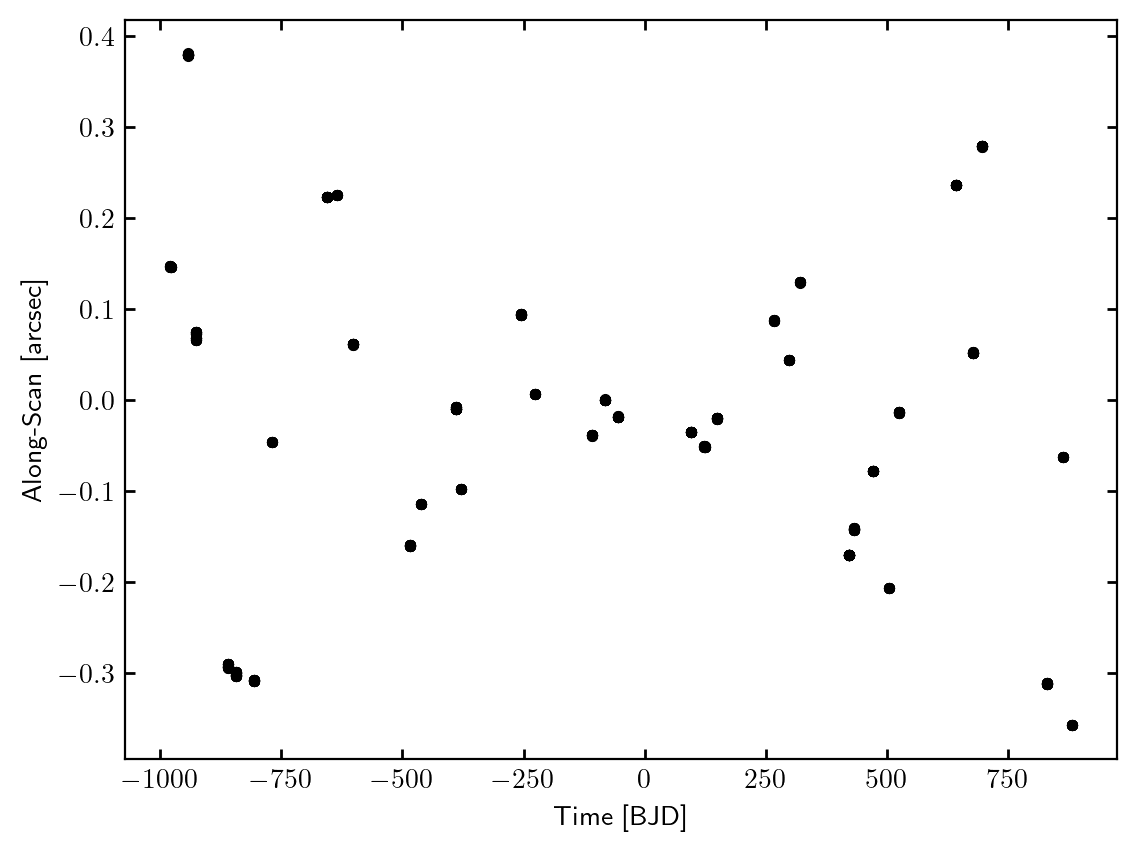

In [4]:
plt.figure()

plt.errorbar(t, w, yerr=sig_w, fmt='o', ms=3, c='k')

plt.xlabel('Time [BJD]')
plt.ylabel('Along-Scan [arcsec]')

plt.show()

In [5]:
mstar = 0.76 # solar masses
rstar = 1. # solar radii; in exoplanet, both mstar and rstar are required

In [6]:
with pm.Model() as model:

    ### Proper motion + parallax modeling ###

    # Stellar position offest
    delta_ra = pm.Normal('delta_ra', mu=0., sigma=1.) # ra*cos(dec), arcsec
    delta_dec = pm.Normal('delta_dec', mu=0., sigma=1.)

    # Stellar proper motion
    pm_ra = pm.Normal('pm_ra', mu=0., sigma=1.) # ra*cos(dec), arcsec/yr
    pm_dec = pm.Normal('pm_dec', mu=0., sigma=1.)
    
    # Parallax
    log_parallax = pm.Normal('log_parallax', mu=np.log(1e-3), sigma=1.) # arcsec
    parallax = pm.Deterministic('parallax', pt.exp(log_parallax))
    
    # Astrometric jitter
    log_sigma = pm.Normal('log_sigma', mu=0., sigma=1.)
    
    # Model prediction
    def single_star_as(t, delta_ra, delta_dec, pm_ra, pm_dec, parallax, pf, psi):

        single_ra = pm.Deterministic('single_ra', pm_ra*t/yr + delta_ra + parallax*pf*pt.sin(psi))
        single_dec = pm.Deterministic('single_dec', pm_dec*t/yr + delta_dec + parallax*pf*pt.cos(psi))

        return (pm_ra*t/yr+delta_ra)*pt.sin(psi) + (pm_dec*t/yr+delta_dec)*pt.cos(psi) + parallax*pf
    
    model_single = pm.Deterministic('model_single', single_star_as(t, delta_ra, delta_dec, pm_ra, pm_dec, parallax, pf, psi))

    ### Binary modeling ###

    # Companion mass
    log_mp = pm.Uniform('log_mp', lower=np.log(1e-3), upper=np.log(1e3), initval=np.log(30)) # solar masses
    mp = pm.Deterministic('mp', pt.exp(log_mp))

    # Period
    log_p = pm.Uniform('log_p', lower=np.log(1e2), upper=np.log(1e5), initval=np.log(1e4)) # days
    p = pm.Deterministic('p', pt.exp(log_p))

    # Time of periastron passage
    tp = pm.Uniform('tp', lower=-0.5*p, upper=0.5*p)

    # Eccentricity and argument of periastron
    h, k = xo.unit_disk('h', 'k', initval=[0.5, 0.5])
    ecc = pm.Deterministic('ecc', h**2 + k**2)
    omega = pm.Deterministic('omega', pt.arctan2(h, k))

    # Inclination
    cosi = pm.Uniform('cosi', lower=-1., upper=1., initval=-0.5) # known retrograde orbit
    i = pm.Deterministic('i', pt.arccos(cosi))

    # Longitude of ascending node
    Omega = xo.angle('Omega', initval=150*np.pi/180)

    # Define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=p, t_periastron=tp, 
                                     incl=i, Omega=Omega,
                                     ecc=ecc, omega=omega, 
                                     m_star=mstar, r_star=rstar,
                                     m_planet=mp)
    
    def binary_as(t, orbit):
        xs, ys, zs = orbit.get_star_position(t, parallax=parallax)

        ra = pm.Deterministic('ra', ys)
        dec = pm.Deterministic('dec', xs)

        # ys in RA direction and xs in Dec direction
        return ys*pt.sin(psi) + xs*pt.cos(psi)
    
    model_binary = pm.Deterministic('model_binary', binary_as(t, orbit))
    
    # Likelihood
    logl = pm.Normal('logl', mu=model_single + model_binary, sigma=pt.sqrt(sig_w**2+pt.exp(log_sigma)**2), observed=w)

    # For plotting
    t_plot = np.linspace(0, 5000, 1000)
    xs_plot, ys_plot, _ = orbit.get_star_position(t_plot, parallax=parallax)
    ra_plot = pm.Deterministic('ra_plot', ys_plot)
    dec_plot = pm.Deterministic('dec_plot', xs_plot)

In [7]:
with model:
    map_soln = pmx.optimize()

Output()

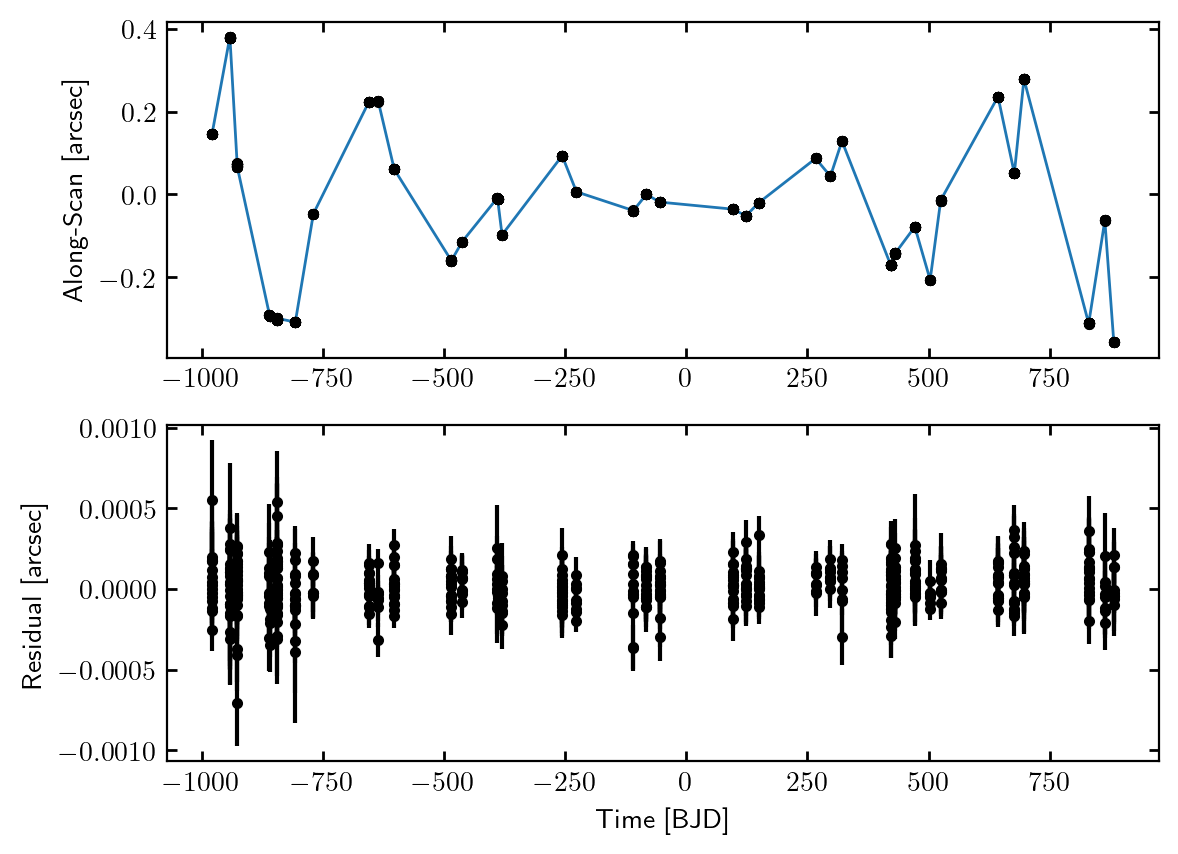

In [8]:
plt.figure()

plt.subplot(2,1,1)
plt.errorbar(t, w, yerr=sig_w, fmt='o', ms=3, c='k')
plt.plot(t, map_soln['model_single'] + map_soln['model_binary'], lw=1)

plt.ylabel('Along-Scan [arcsec]')

plt.subplot(2,1,2)
plt.errorbar(t, w-map_soln['model_single']-map_soln['model_binary'], yerr=sig_w, fmt='o', ms=3, c='k')

plt.xlabel('Time [BJD]')
plt.ylabel('Residual [arcsec]')

plt.show()

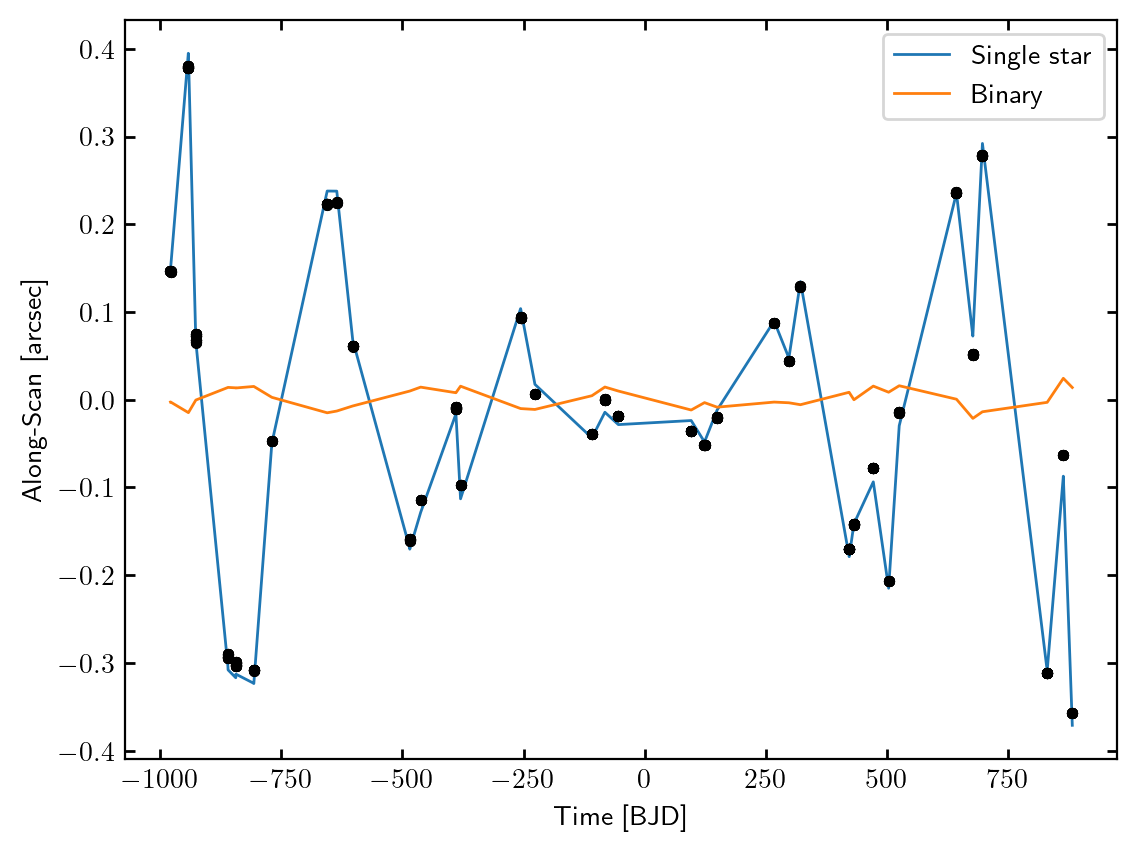

In [9]:
plt.figure()

plt.errorbar(t, w, yerr=sig_w, fmt='o', ms=3, c='k')

plt.plot(t, map_soln['model_single'], lw=1, label='Single star')
plt.plot(t, map_soln['model_binary'], lw=1, label='Binary')

plt.ylabel('Along-Scan [arcsec]')
plt.xlabel('Time [BJD]')

plt.legend()

plt.show()

In [10]:
with model:
    idata = pm.sample(initvals=map_soln, target_accept=0.9, init="adapt_full")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/jdong/mambaforge/envs/xo24/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_ra, delta_dec, pm_ra, pm_dec, log_parallax, log_sigma, log_mp, log_p, tp, h, __k_unit_disk, cosi, __Omega_angle1, __Omega_angle2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [11]:
import arviz as az
az.summary(idata, var_names=['delta_ra', 'delta_dec', 'pm_ra', 'pm_dec', 'log_parallax', 'parallax', 'log_sigma', 
                             'log_mp', 'mp', 'log_p', 'p', 'ecc', 'omega', 'cosi', 'i', 'Omega', 'tp'], 
           round_to=8)

mean          sd       hdi_3%      hdi_97%     mcse_mean  \
delta_ra         0.004265    0.000064     0.004145     0.004381  1.040000e-06   
delta_dec        0.002421    0.000092     0.002250     0.002596  1.820000e-06   
pm_ra           -0.028330    0.000081    -0.028484    -0.028179  1.670000e-06   
pm_dec          -0.155194    0.000135    -0.155440    -0.154934  2.960000e-06   
log_parallax    -6.387247    0.005962    -6.398805    -6.376387  7.945000e-05   
parallax         0.001683    0.000010     0.001664     0.001701  1.400000e-07   
log_sigma       -9.970868    0.154057   -10.242844    -9.677695  2.401960e-03   
log_mp           3.502802    0.020359     3.464329     3.541294  3.177300e-04   
mp              33.215244    0.676575    31.955015    34.511538  1.054476e-02   
log_p            8.350487    0.027917     8.296889     8.402438  6.153700e-04   
p             4233.891231  118.412710  4011.372719  4457.920356  2.609000e+00   
ecc              0.728091    0.005759     0.716943     0.738687  1.256900e-04   
omega            1.358699    0.003160     1.353184     1.364979  4.308000e-05   
cosi            -0.351500    0.001796    -0.354653    -0.347961  2.797000e-05   
i                1.929970    0.001919     1.926192     1.933340  2.987000e-05   
Omega            2.377148    0.002665     2.372248     2.382150  5.896000e-05   
tp             240.560737    1.049384   238.560524   242.494403  1.536785e-02   

                   mcse_sd     ess_bulk     ess_tail     r_hat  
delta_ra      7.300000e-07  3838.527440  3156.410908  1.000942  
delta_dec     1.280000e-06  2538.717398  2539.051408  1.001831  
pm_ra         1.180000e-06  2345.934410  2464.341291  1.001422  
pm_dec        2.100000e-06  2063.430576  2355.512601  1.000673  
log_parallax  5.618000e-05  5656.084769  2723.194152  1.000820  
parallax      1.000000e-07  5656.084769  2723.194152  1.000811  
log_sigma     1.712520e-03  4852.342438  1964.487892  1.000316  
log_mp        2.246800e-04  4124.402364  2338.974678  1.000622  
mp            7.456800e-03  4124.402364  2338.974678  1.000628  
log_p         4.352000e-04  2055.276381  2203.402523  1.001227  
p             1.845103e+00  2055.276381  2203.402523  1.001262  
ecc           8.889000e-05  2099.219842  2371.322718  1.001664  
omega         3.046000e-05  5378.965895  2842.965007  1.000315  
cosi          1.978000e-05  4137.129487  3448.272662  1.002112  
i             2.112000e-05  4137.129487  3448.272662  1.002110  
Omega         4.170000e-05  2040.261959  2545.873702  1.001051  
tp            1.086739e-02  4657.776980  2783.116421  1.001153

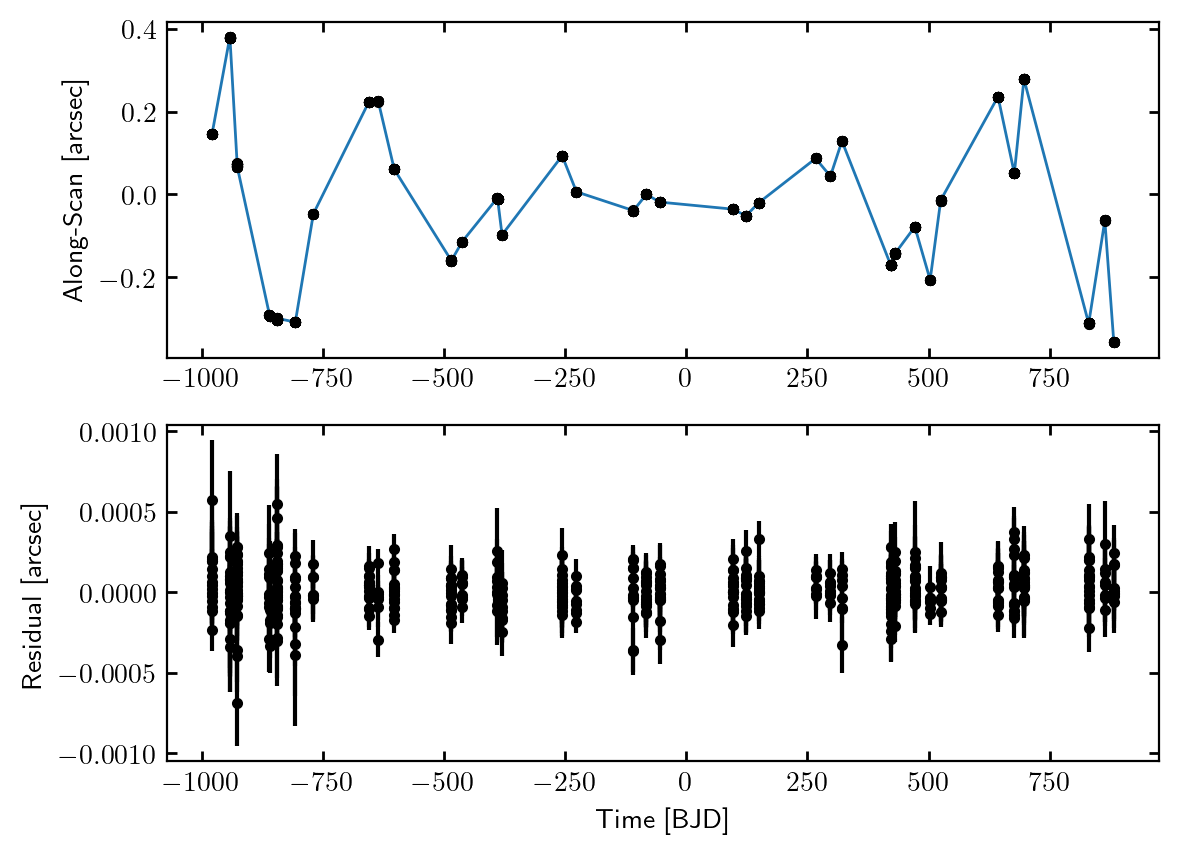

In [12]:
plt.figure()

plt.subplot(2,1,1)
plt.errorbar(t, w, yerr=sig_w, fmt='o', ms=3, c='k')

as_pred = idata.posterior['model_single'].values + idata.posterior['model_binary'].values
q16, q50, q84 = np.percentile(as_pred, [16, 50, 84], axis=(0, 1))

plt.plot(t, q50, lw=1)
plt.fill_between(t, q16, q84, alpha=0.3)

plt.ylabel('Along-Scan [arcsec]')

plt.subplot(2,1,2)
plt.errorbar(t, w-q50, yerr=sig_w, fmt='o', ms=3, c='k')

plt.xlabel('Time [BJD]')
plt.ylabel('Residual [arcsec]')

plt.show()

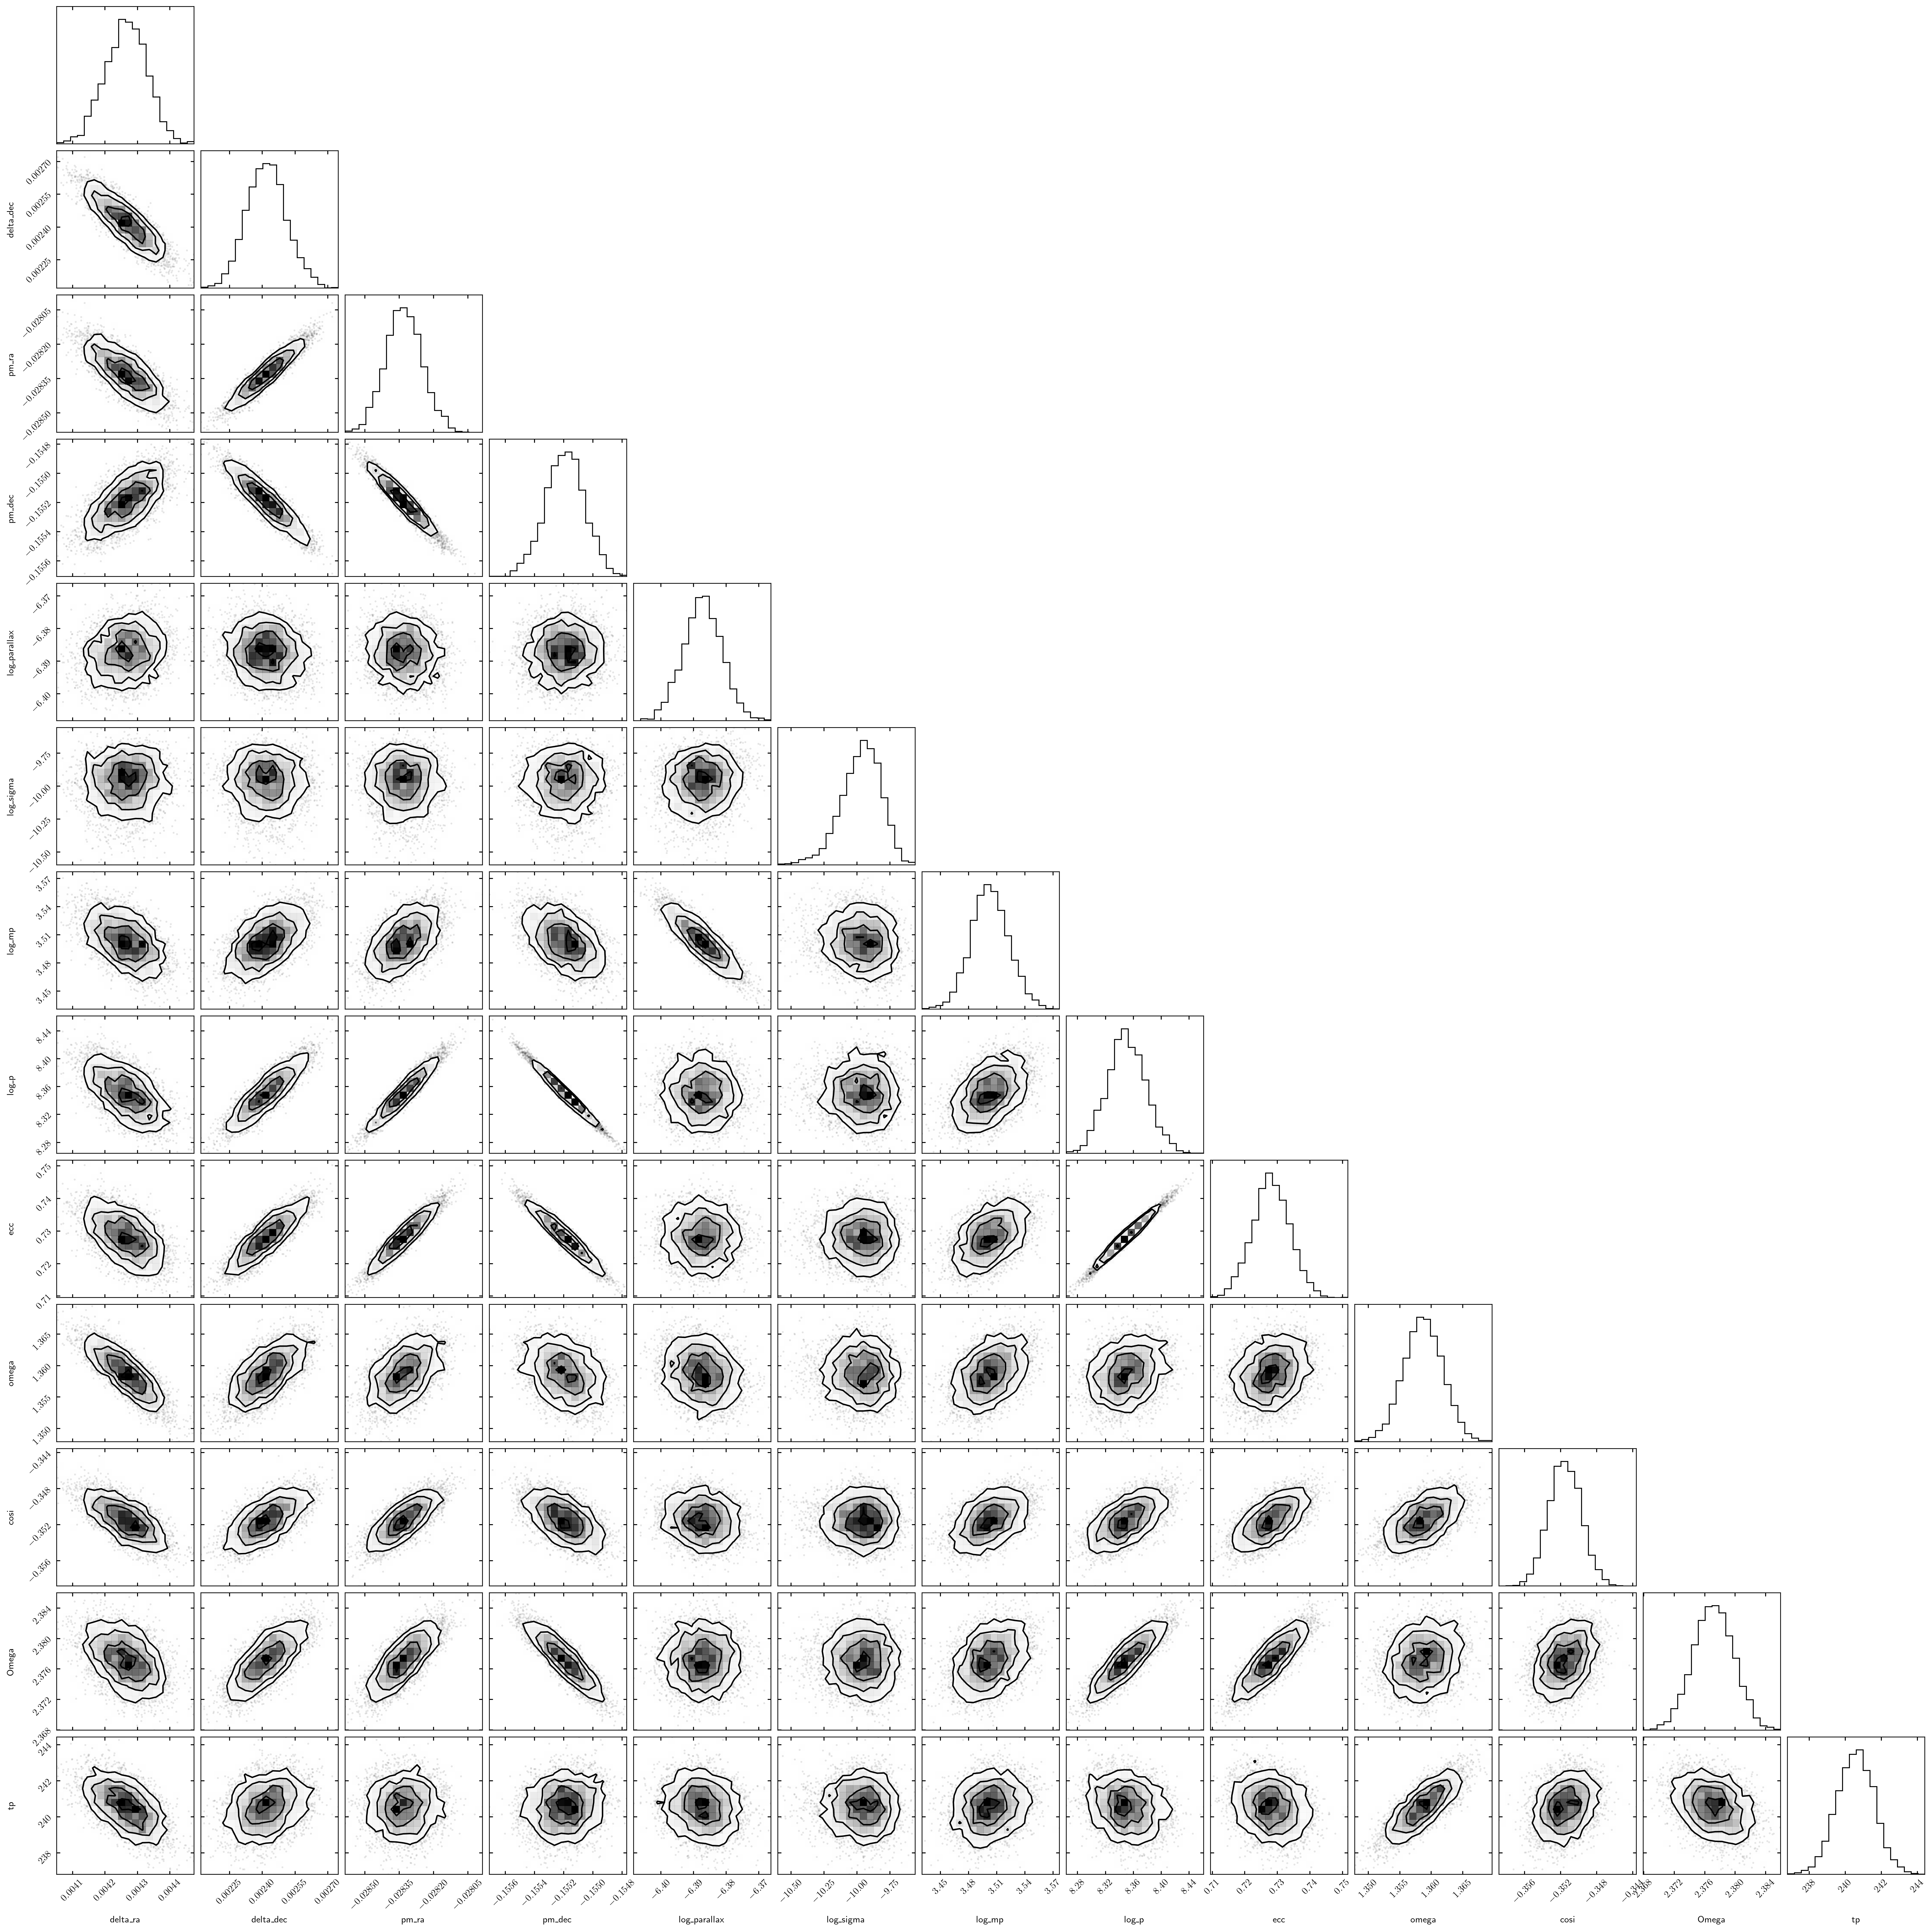

In [13]:
import corner
fig = corner.corner(idata.posterior, 
              var_names=['delta_ra', 'delta_dec', 'pm_ra', 'pm_dec', 'log_parallax', 'log_sigma', 
                         'log_mp', 'log_p', 'ecc', 'omega', 'cosi', 'Omega', 'tp']);

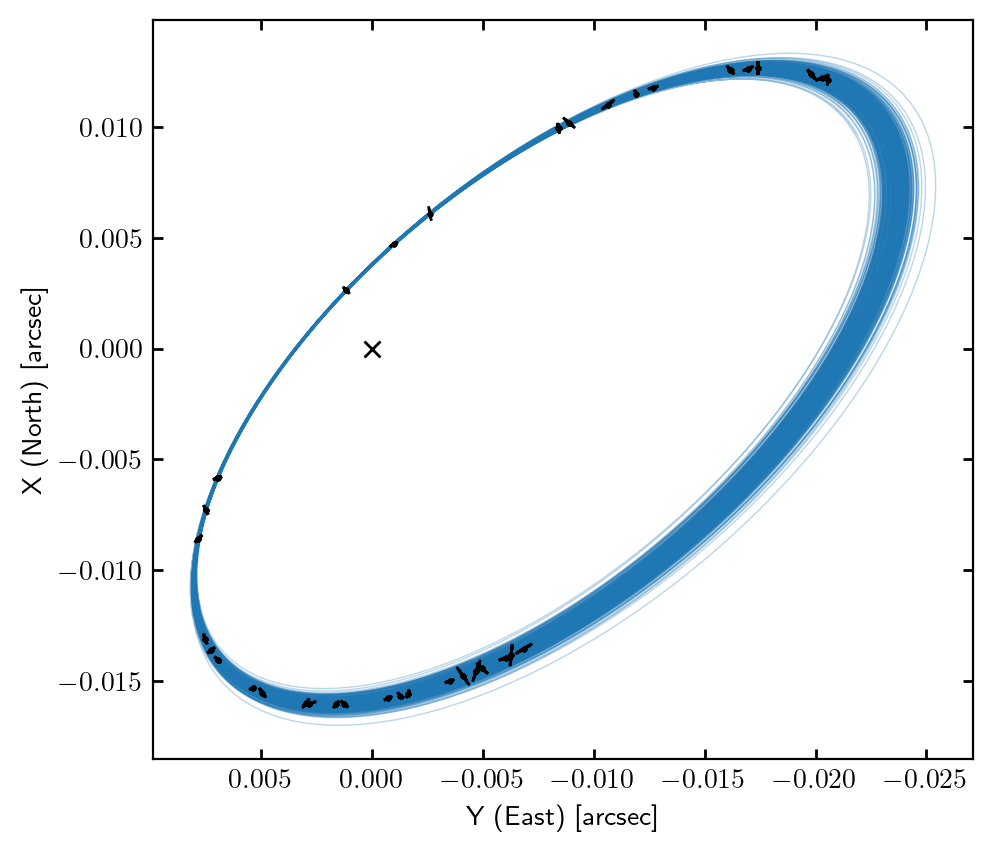

In [14]:
fig = plt.figure()

plt.plot(0, 0, marker='x', c='k')

ra_plot = idata.posterior['ra_plot'].values
dec_plot = idata.posterior['dec_plot'].values

# 300 draws from the posterior
for i in range(300):
    m = np.random.randint(0, ra_plot.shape[0])
    n = np.random.randint(0, ra_plot.shape[1])
    plt.plot(ra_plot[m,n,:], dec_plot[m,n,:], lw=0.5, c='C0', alpha=0.3)

# plot "data"

jitter = np.exp(np.median(idata.posterior.log_sigma.values.flatten()))

for i in range(len(t)):
    this_ra = idata.posterior.ra.values[:,:,i].flatten()
    this_dec = idata.posterior.dec.values[:,:,i].flatten()

    # median position and uncertainty out of model
    med_ra = np.median(this_ra)
    med_dec = np.median(this_dec)

    sd_ra = np.sqrt(sig_w[i]**2 + jitter**2)*np.sin(psi[i])
    sd_dec = np.sqrt(sig_w[i]**2 + jitter**2)*np.cos(psi[i])

    plt.plot([med_ra - sd_ra, med_ra + sd_ra], [med_dec - sd_dec, med_dec + sd_dec], c='k', lw=1)      
    plt.plot(med_ra, med_dec, marker='o', linestyle=' ', c='k', ms=1)

plt.xlabel('Y (East) [arcsec]')
plt.ylabel('X (North) [arcsec]')

plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')

plt.show()